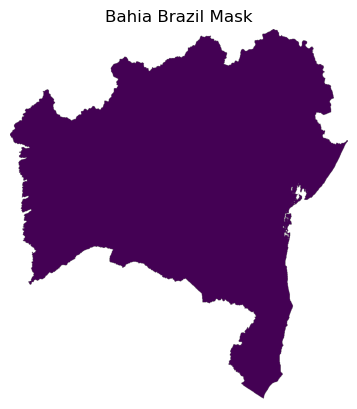

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import georaster
import importlib
import pandas as pd
import itertools as iter
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dropout, Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D,  Conv2D, Dense, Dropout, Flatten, Input, AveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping


import os, sys
root = os.getcwd() + "/.."
sys.path.insert(0, root)

import src.deforestation_utils as du
importlib.reload(du)

directory = "../data/processed/gtiff/mask_bahia_gtiff"

bahia_mask = du.readMask(directory)
plt.imshow(bahia_mask)
plt.title("Bahia Brazil Mask")
plt.axis("off")
plt.show()

Text(0, 0.5, 'Latitude')

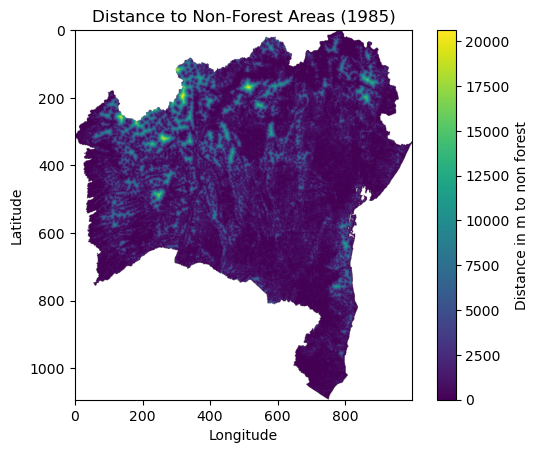

In [25]:
# Cargar el mapa en arreglo numpy
D2NF = du.loadMapinNumpy()

# Convertir el mapa a DataFrame
dim = D2NF.shape[0] * D2NF.shape[1]
bahia_D2NF = pd.DataFrame(D2NF.reshape(dim, -1), columns=[year for year in range(1985, 2021)])

# Mostrar el mapa del año 1985
plt.imshow(bahia_D2NF[1985].to_numpy().reshape(D2NF.shape[0], -1), cmap='viridis')

# Agregar barra de color con leyenda
cbar = plt.colorbar()
cbar.set_label("Distance in m to non forest", fontsize=10)

# (Opcional) agregar título o etiquetas
plt.title("Distance to Non-Forest Areas (1985)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

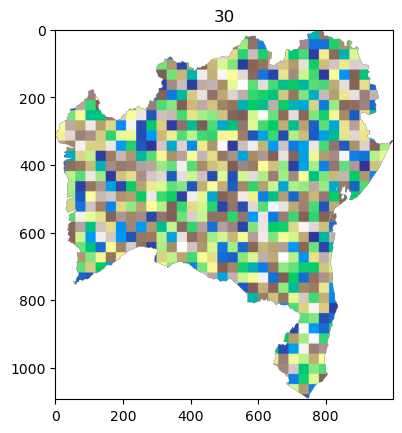

In [26]:
#num de pixeles en cada celda de grid a resolucion mas baja


yinit=1985
yend = 2020
years = np.arange(yinit, yend + 1)

#pixels per grid cell 
CELLSXGRIDCELL = 30

F = int(np.ceil(bahia_mask.shape[0]/CELLSXGRIDCELL))
RES = int(np.ceil(bahia_mask.shape[0]/F))
bahia_DF = (bahia_D2NF==0)
for g in np.arange(RES, RES+1, RES):
   

    a, b = np.array(bahia_mask.shape)
    GRID = du.makeGrid(a, b, g)


    G = np.arange(GRID.flatten()[-1]+1)
    GRID_SHUFFLE = np.random.shuffle(G)
    GRID_FLATTEN = GRID.flatten()
    GR = G[GRID_FLATTEN].reshape(GRID.shape)
    
    #plt.imshow(GRID*bahia_mask, cmap="tab20")
    plt.imshow(GR*bahia_mask, cmap="terrain")
    plt.title(g)
    plt.show()
    
    column_name = "Grid{n}".format(n=g) 
    bahia_D2NF[column_name] = GRID.flatten()
    bahia_DF[column_name] = GRID.flatten()
    DF = bahia_DF.groupby(column_name)[years].sum()




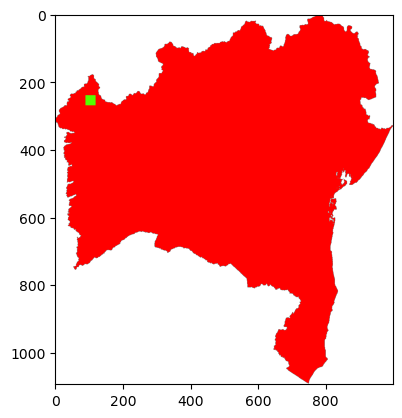

In [27]:


plt.imshow((GRID==275)*bahia_mask, cmap="prism")



In [28]:
COLUMNS = ["grid_code", "bin_distances", 1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996, 1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012, 2013, 2014, 2015, 2016,2017,2018,2019, 2020]


In [29]:
last_index = bahia_DF.index[-1]
last_grid_code = bahia_DF["Grid30"][last_index]


Generamos todas las series de tiempo de Histogramas de Frecuencia para cada celda de 30m x 30m en la región de Bahía.

In [30]:
#last_grid_code = bahia_DF["Grid30"][last_index]
#c = last_grid_code
#c = 628
bin_size = 1000

bins = np.arange(bin_size, 10000+bin_size, bin_size)

#DF = pd.DataFrame(columns=COLUMNS)
PD = [0]
ZZ= np.zeros((1,36+2))
max = -1


for c in range(0, last_grid_code):
#for c in [275]:

    
    #miniframe de 5 bins y 38 columnas: 36 años + 1 de distancias y 1 de gridcode
    #print(c)
    Z = np.zeros((len(bins), 36+2))
    Z[:,0] = [c]*len(bins)
    Z[:,1] = bins



    for i, YEAR in enumerate(range(1985, 2020)):
        #YEAR = 1985
        
        #we retrieve the indexes of the cell c for all the years
        GRIDCELL = bahia_DF["Grid30"] == c
        GRIDCELL_DF = bahia_D2NF[GRIDCELL]

        #we retrieve the deforestable cells for a specific YEAR
        Deforestable_grid_cells = GRIDCELL_DF[YEAR]>0

        #check deforestation gain in Y+1  
        deforastationGain = GRIDCELL_DF[YEAR+1][Deforestable_grid_cells]==0

        #distance from deforestable to nonforest (barren) edge
        distances = GRIDCELL_DF[YEAR][Deforestable_grid_cells]
        #print("max distance:", np.max(distances))

        distance_bin = list([])
        deforestation_at_distance_bin = list([])
    
        for dist in bins:
            deforestation_at_distance_bin.append(np.sum(deforastationGain[((dist-bin_size)<distances) & (distances<=dist)]))
            distance_bin.append(dist)   


 
        
        if np.sum(deforestation_at_distance_bin)>0:
            Z[:, i+2] = np.array(deforestation_at_distance_bin/np.sum(deforestation_at_distance_bin))
            A = np.copy(Z[:,2:])
            dummy = np.sum(A, axis=0)==0
            A[0,dummy]=1
            Z[:,2:] = A

    if np.sum(Z[:,2:]) > 0:
        ZZ = np.vstack((ZZ,Z))
        if c ==279:
            ZZZ = Z[:,2:]
        #plt.imshow(Z[:,2:])
       # plt.title("cell: {s}".format(s= c))
        if np.sum(Z[:,2:]>0)>max:
            max =  np.sum(Z[:,2:]>0)
            bestc = c

        plt.show()


**Generación de histogramas en el tiempo para representar la distribución de deforestación en el tiempo**

Este es un ejemplo de secuencia de histogramas locales de deforestación para la celda 275.  
Se tienen histogramas desde 1985 hasta 2020 (35 años).  
La suma de cada columna que representa un histograma en un año siempre es igual a 1.  
Por ejemplo, se observa que la deforestación se concentra dentro de 1000mts al suelo defoerstado, pero con algunos años con deforestación a mayores distancias.  


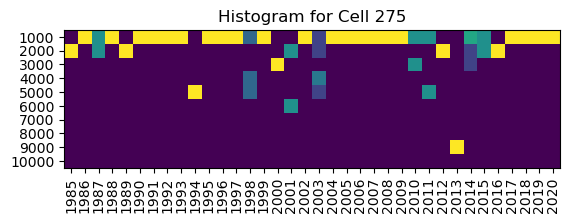

In [32]:
plt.imshow(ZZZ)
plt.title("Histogram for Cell {c}".format(c = 275, y = 1985+i))
plt.yticks(ticks=np.arange(0, 10, 1), labels=np.arange(1000, 1000*11, 1000))
plt.xticks(ticks=np.arange(0, 36, 1), labels=np.arange(0, 36, 1)+1985, rotation = 90)
plt.show()

In [33]:
ZZc = np.copy(ZZ[1:,2:])
C = int(ZZc.shape[0]/10)

In [34]:
XTRH = list([])
YTRH = list([])



XTEH = list([])
YTEH = list([])


#grid cell number
#c = 3

for c in range(705):



    #prediction for H steps ahead
    H = 3

    #number of observed year to produce a prediction
    LAGS = 4

    #time 

    for t in range(36-H-LAGS):
        
        if t < 15:
            Xind = ZZ[c*10:c*10+10, 2+t:2+t+LAGS]

            Y = np.zeros((10,2))
            Y[:,0] = ZZ[c*10:c*10+10, 2+t+LAGS+H-1]
            Y[:,1] = ZZ[c*10:c*10+10, 2+t+LAGS+H-1]


            if len(XTRH)==0:
                XTRH = [Xind]
                YTRH = Y[:,0]
            else:
                XTRH = np.vstack((XTRH, [Xind]))
                YTRH = np.vstack((YTRH, Y[:,0]))

        else:

            Xind = ZZ[c*10:c*10+10, 2+t:2+t+LAGS]

            Y = np.zeros((10,2))
            Y[:,0] = ZZ[c*10:c*10+10, 2+t+LAGS+H-1]
            Y[:,1] = ZZ[c*10:c*10+10, 2+t+LAGS+H-1]


            if len(XTEH)==0:
                XTEH = [Xind]
                YTEH = Y[:,0]
            else:
                XTEH = np.vstack((XTEH, [Xind]))
                YTEH = np.vstack((YTEH, Y[:,0]))
                #plt.imshow(Xind)
                #plt.show()


        

**Este es una red neuronal con 3 capas densas que reciben la historia de 3 histogramas en el pasado para asociarla a su siguiente histograma**

In [35]:
input_shape = (10,1,1)
print(input_shape)
i = Input(shape=input_shape)


x = Flatten()(i)
x = Dense(40, activation='leaky_relu')(x)
x = Dense(20, activation='leaky_relu')(x)
x = Dense(20, activation='leaky_relu')(x)
x = Dense(YTRH.shape[1], activation='sigmoid')(x)
model = Model(i, x)

model.summary()





(10, 1, 1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 40)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,890 (7.38 KB)

 Trainable params: 1,890 (7.38 KB)

 Non-trainable params: 0 (0.00 B)

**Entrenamos el modelo y lo probamos**

In [ ]:
#C = np.array([  94,  400,  928,  247,  305, 1219,  497,  832,  422, 275])

C = int(ZZc.shape[0]/10)

obs = 1
c = 0
H = 18 

enaive = list([])
eann   = list([])

for H in np.arange(18, 36):


    Xtr = list([])
    Ytr = list([])

    Xva = list([])
    Yva = list([])

    for c in np.arange(C):
        
        Xtr.append([ZZc[c*kbins : c*kbins+kbins, H-obs-1:H-1]])
        Ytr.append([ZZc[c*kbins : c*kbins+kbins, H-1]])

        Xva.append([ZZc[c*kbins : c*kbins+kbins, H-obs:H]])
        Yva.append([ZZc[c*kbins : c*kbins+kbins, H]])


    Xtr = np.array(Xtr)
    Ytr = np.array(Ytr)

    Xva = np.array(Xva)
    Yva = np.array(Yva)



    Xtr = Xtr.reshape(Xtr.shape[0],Xtr.shape[2], Xtr.shape[3],1)
    Ytr = np.array(Ytr)

    Xva = Xva.reshape(Xva.shape[0],Xva.shape[2], Xva.shape[3],1)
    Yva = np.array(Yva)


#Xtr.reshape(Xtr[0],Xtr.shape[2],Xtr.shape[3],1)
#Xva.reshape(Xva[0],Xva.shape[2],Xtr.shape[3],1)


    model.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

    # EarlyStopping callback
    callback = EarlyStopping(monitor='loss', patience = 10, restore_best_weights = True) # se carguen los pesos con la mejor pérdida de validación después de que el entrenamiento se detenga.
    MDL = model.fit(Xtr, Ytr, validation_data = (Xva, Yva) , epochs = 2000, callbacks = [callback], batch_size = 100)


    Yhat = model.predict(Xva)

    en = np.mean((Ytr.reshape(705,-1) - Yva.reshape(705,-1))**2)
    ea = np.mean((Ytr.reshape(705,-1) - Yhat)**2)

    enaive.append(en)
    eann.append(ea)
    print(eann[-1])
    print(enaive[-1])

Epoch 1/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2380 - mean_absolute_error: 0.4839 - mean_squared_error: 0.2380 - val_loss: 0.2315 - val_mean_absolute_error: 0.4769 - val_mean_squared_error: 0.2315
Epoch 2/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2275 - mean_absolute_error: 0.4729 - mean_squared_error: 0.2275 - val_loss: 0.2196 - val_mean_absolute_error: 0.4642 - val_mean_squared_error: 0.2196
Epoch 3/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2148 - mean_absolute_error: 0.4592 - mean_squared_error: 0.2148 - val_loss: 0.2053 - val_mean_absolute_error: 0.4483 - val_mean_squared_error: 0.2053
Epoch 4/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1989 - mean_absolute_error: 0.4412 - mean_squared_error: 0.1989 - val_loss: 0.1860 - val_mean_absolute_error: 0.4256 - val_mean_squared_error: 0.1860
Epoch 5/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1774 - mean_absolute_error: 0.4153 - mean_squared_error: 0.1774 - val_loss: 0.1608 - val_mean_absol

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10, 1) + inhomogeneous part.

**Comparamos el desempeño considerando los ultimos 17 años como periodo de prueba**

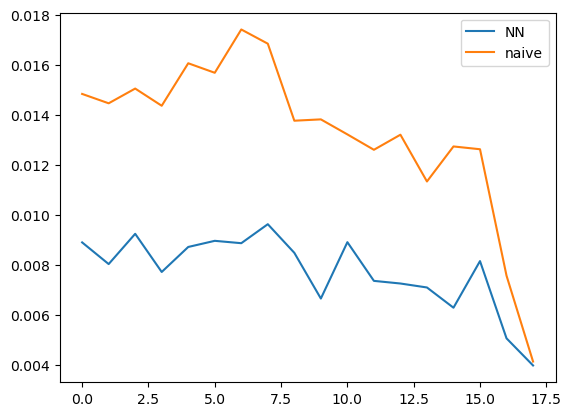

In [ ]:
plt.plot(eann, label = "NN")
plt.plot(enaive, label = "naive")
plt.legend()

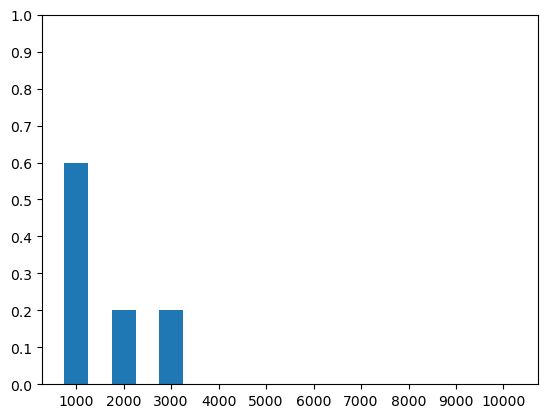

In [ ]:
plt.bar(np.arange(1000, 1000*11, 1000), ZZZ[:,18+11], width = 500)

# Set custom ticks and labels
plt.xticks(ticks=np.arange(1000, 1000*11, 1000), labels=np.arange(1000, 1000*11, 1000))
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=np.round(np.arange(0,1.1,0.1),2))

plt.show()

0


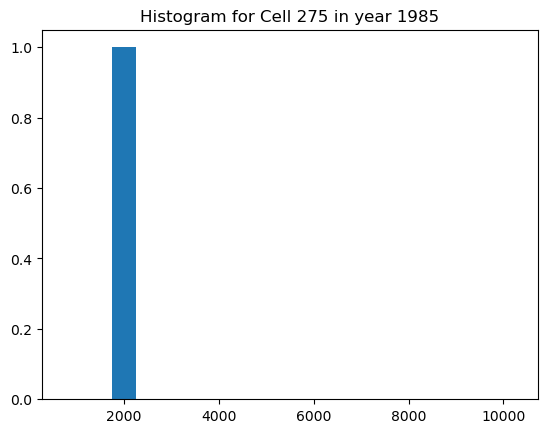

1


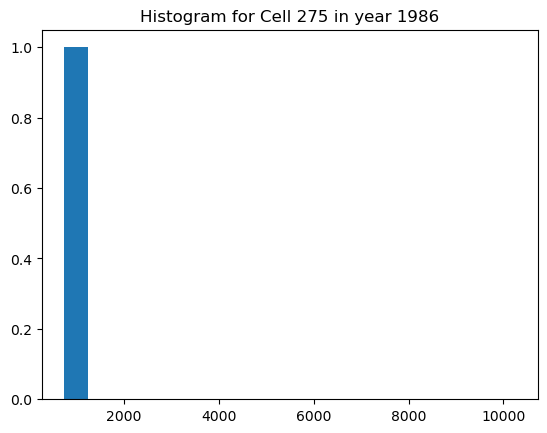

2


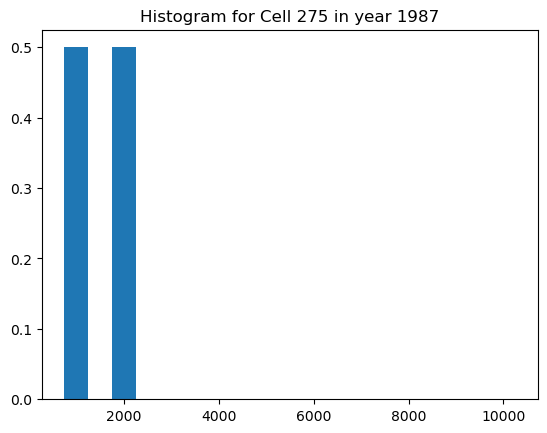

3


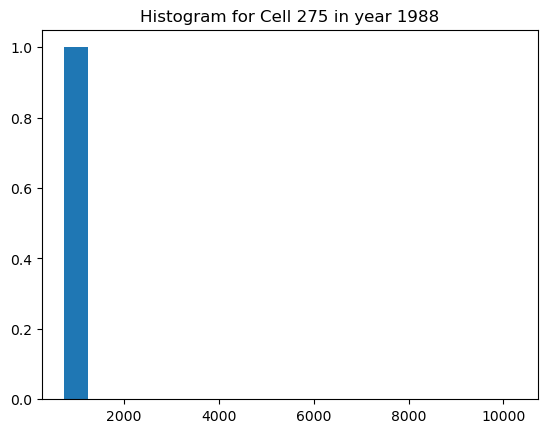

4


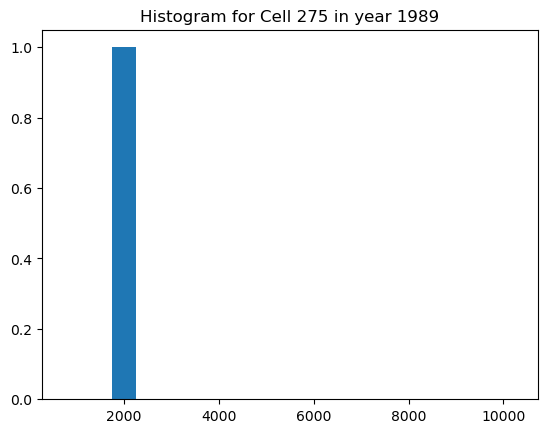

5


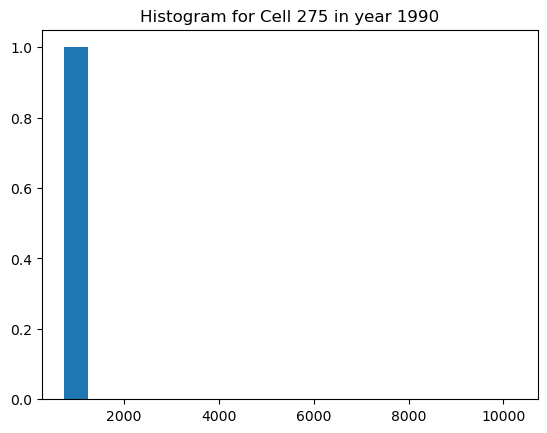

6


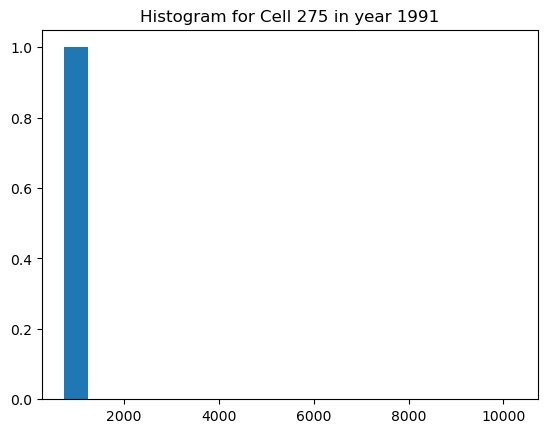

7


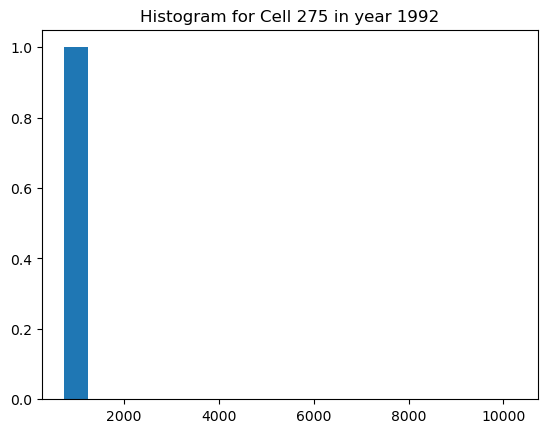

8


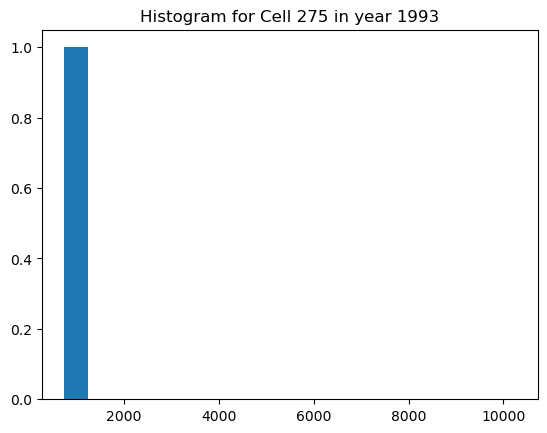

9


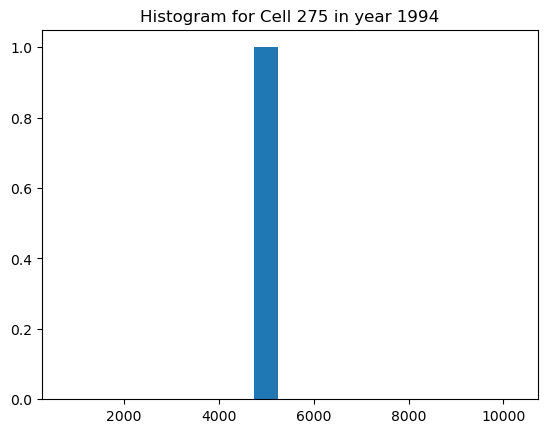

10


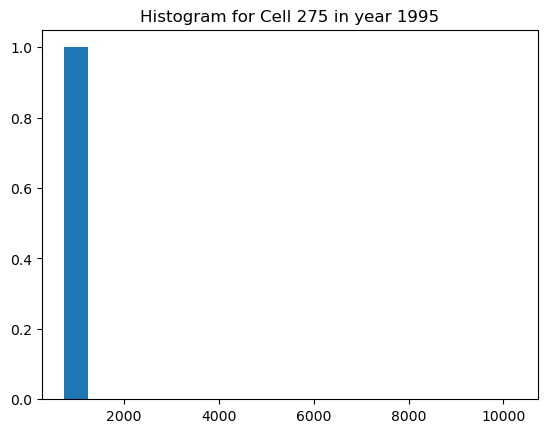

11


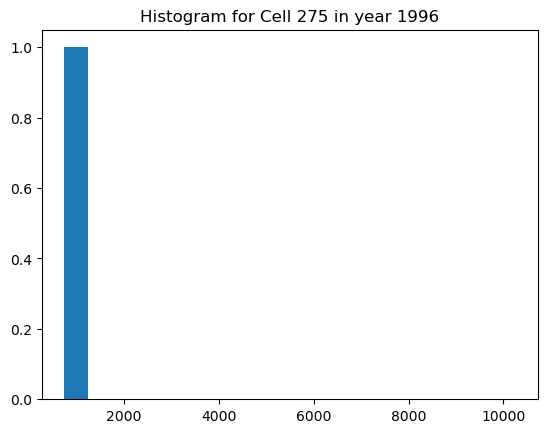

12


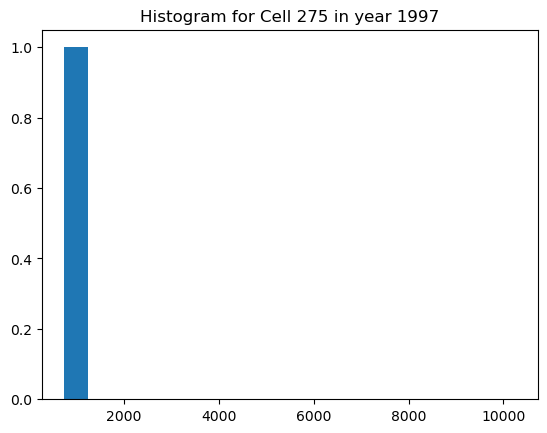

13


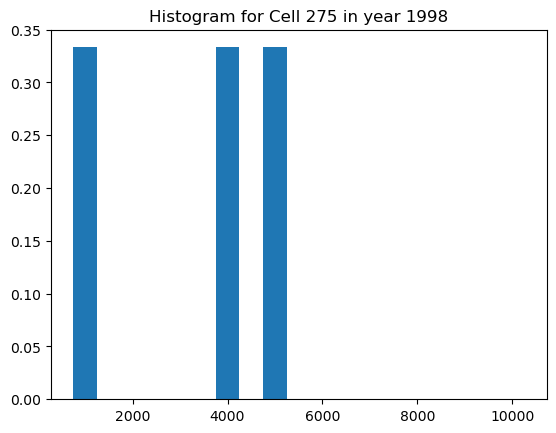

14


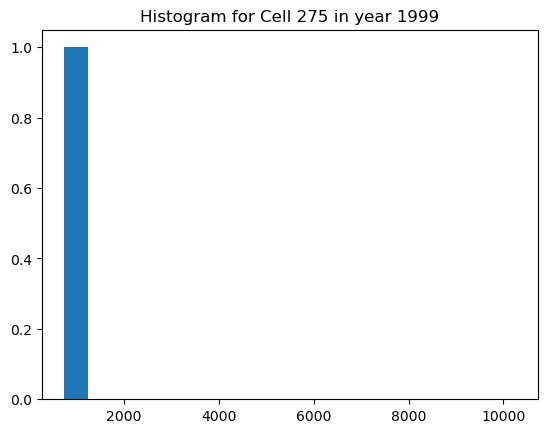

15


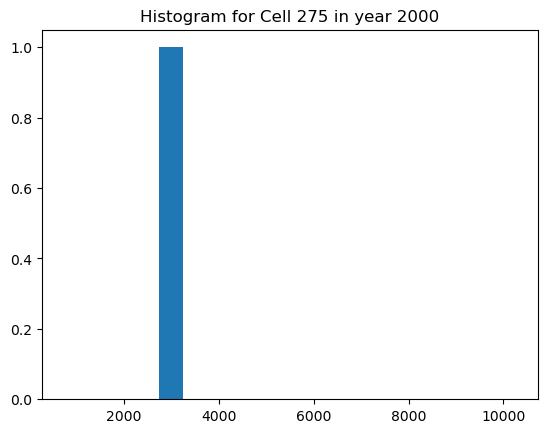

16


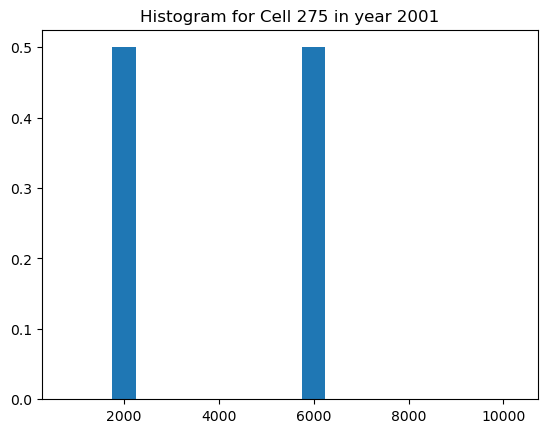

17


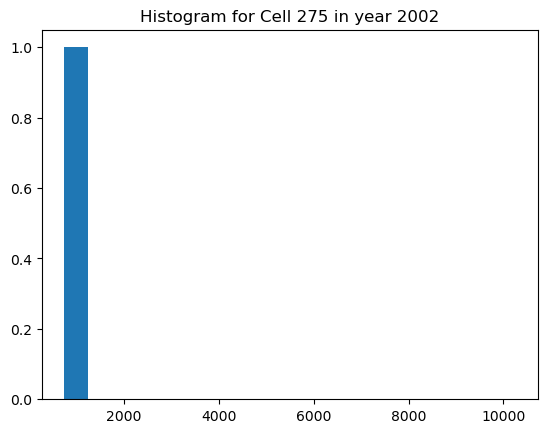

18


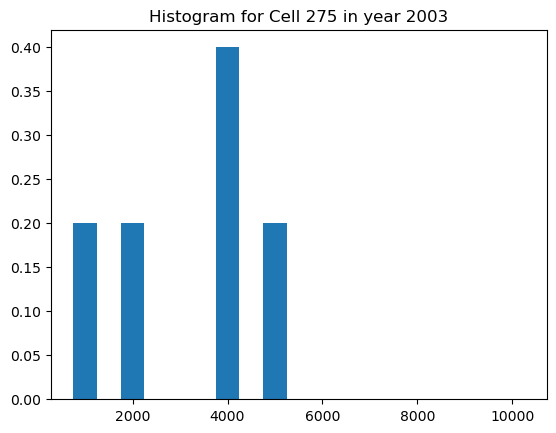

19


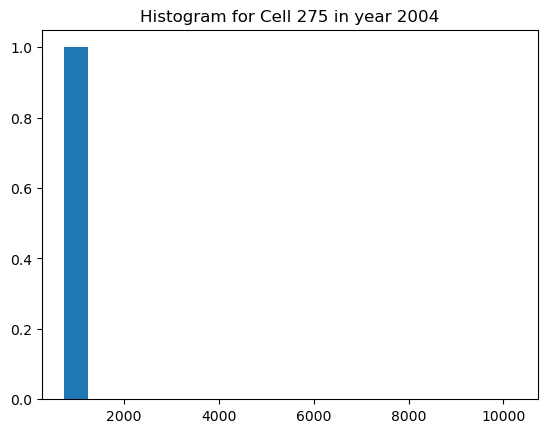

20


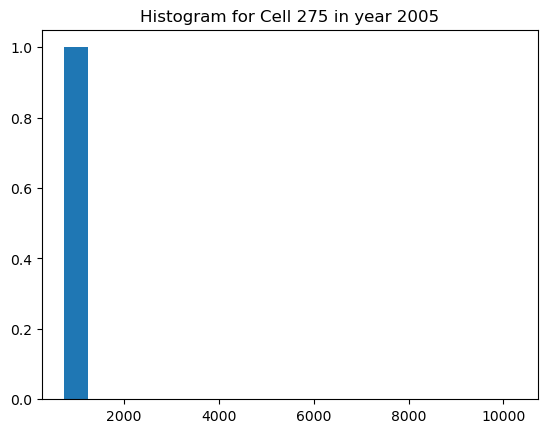

21


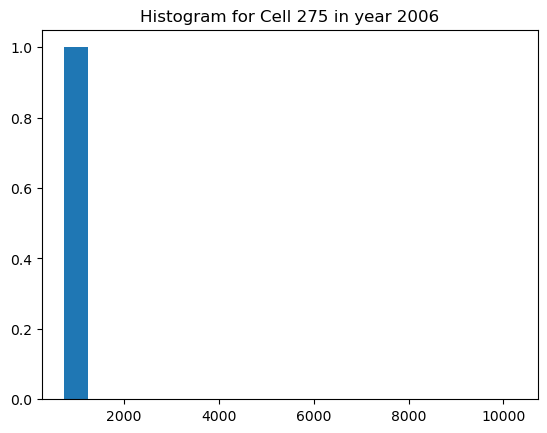

22


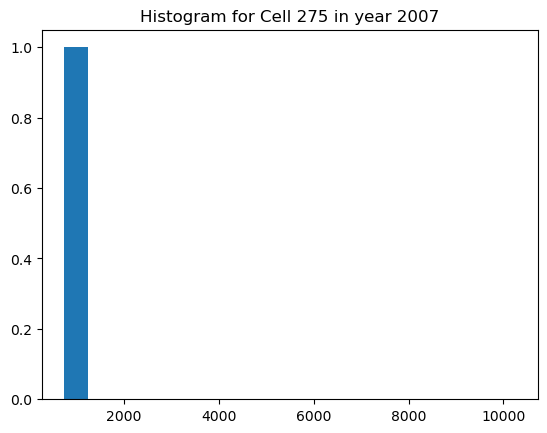

23


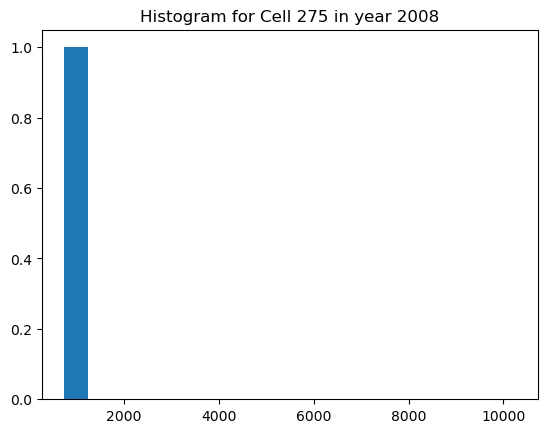

24


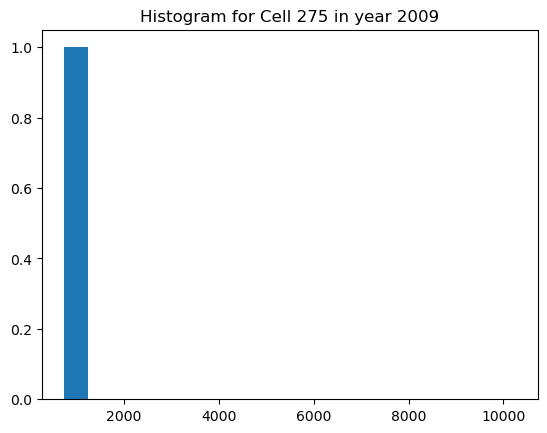

25


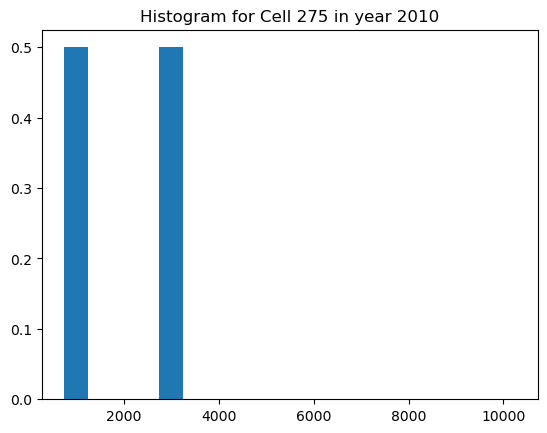

26


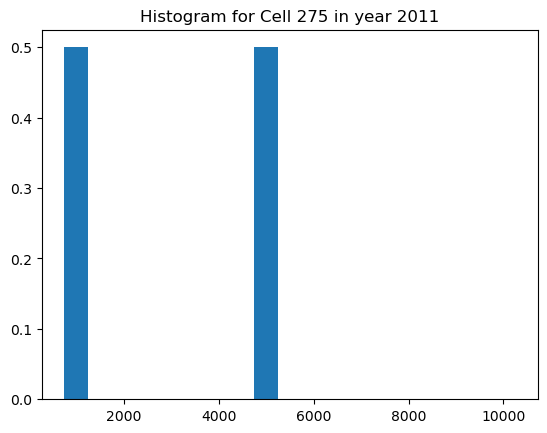

27


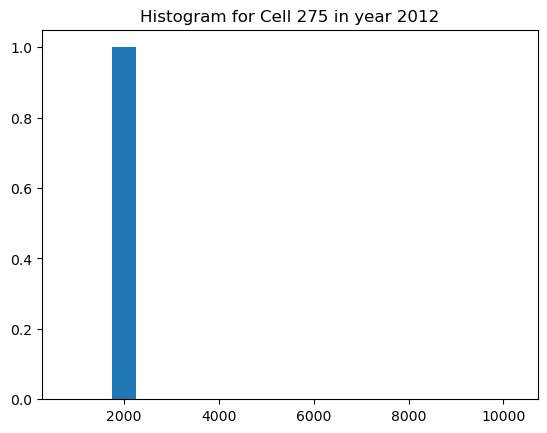

28


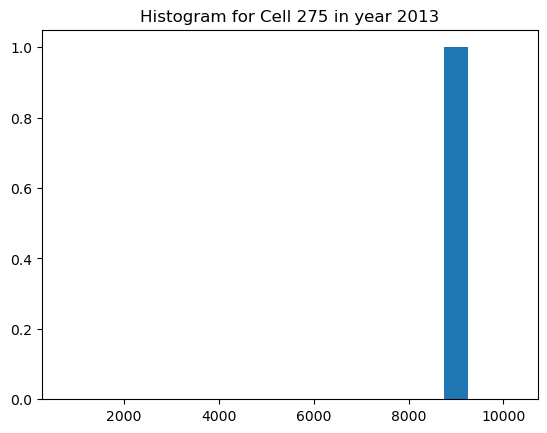

29


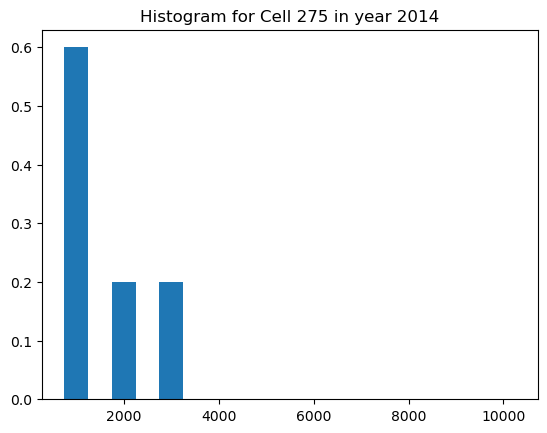

30


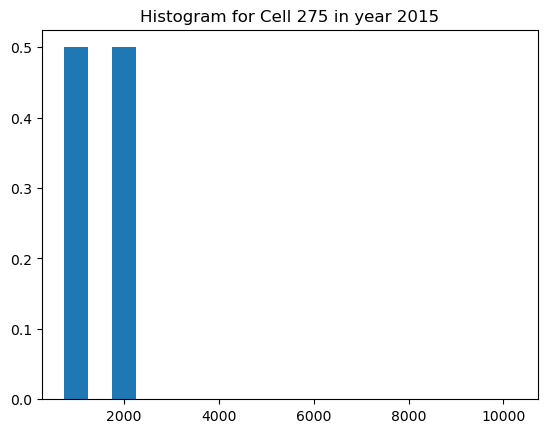

31


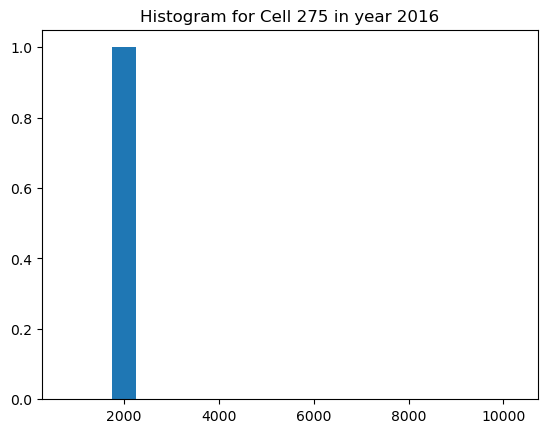

32


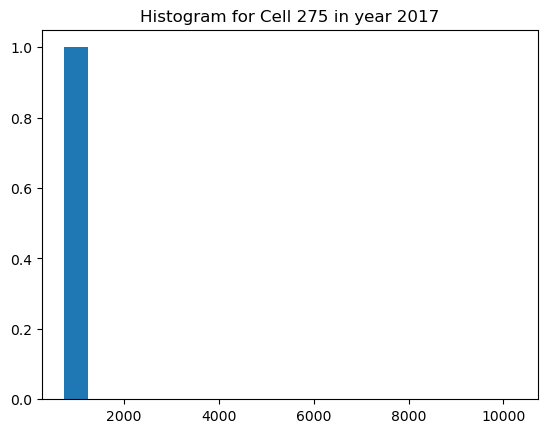

33


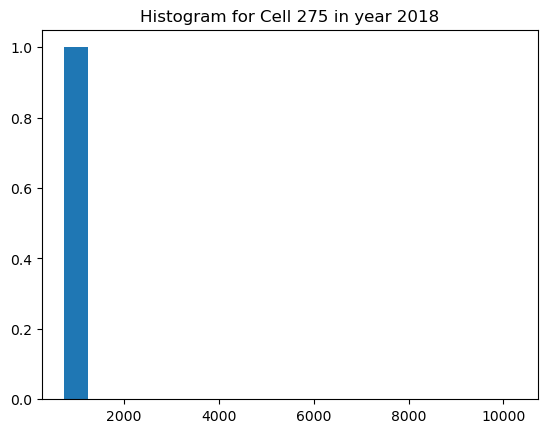

34


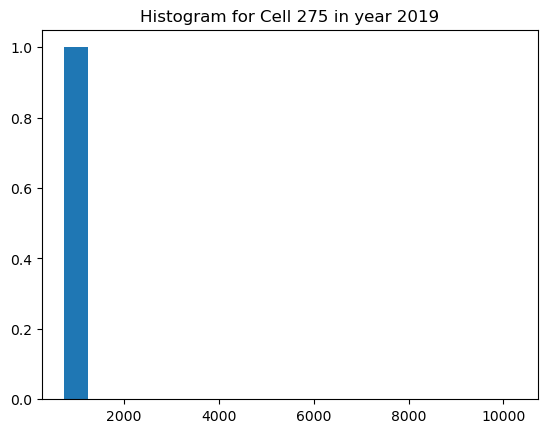

35


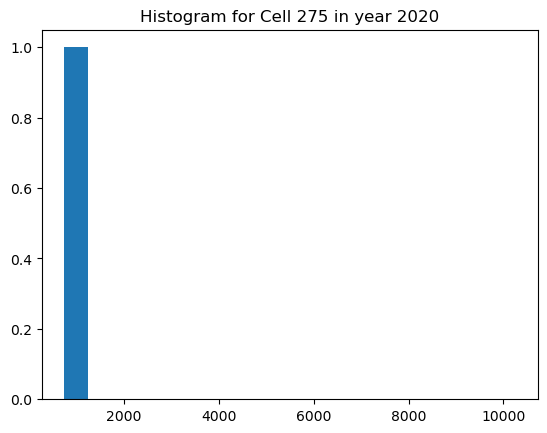

In [ ]:
for i in range(36):
    print(i)
    plt.bar(np.arange(1000, 1000*11, 1000), ZZZ[:,i], width = 500)
    plt.title("Histogram for Cell {c} in year {y}".format(c = 275, y = 1985+i))
    plt.show()

In [ ]:
ZZ = np.delete(ZZ, (0), axis=0)

705.0

In [ ]:
H = 1
E = 4

In [ ]:
print(XTRH[0].shape)
print(YTRH.shape)


(10, 4)
(10575, 10)


In [24]:
input_shape = XTRH[0].shape
print(input_shape)
i = Input(shape=input_shape)

# Primera capa convolucional con activación ReLU

x = Flatten()(i)
x = Dense(40, activation='leaky_relu')(x)
x = Dense(20, activation='leaky_relu')(x)
x = Dense(20, activation='leaky_relu')(x)
x = Dense(YTRH.shape[1], activation='sigmoid')(x)
model = Model(i, x)

model.summary()

(10, 4)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,090 (12.07 KB)

 Trainable params: 3,090 (12.07 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:

model.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

 # EarlyStopping callback
callback = EarlyStopping(monitor='loss', patience = 10, restore_best_weights = True) # se carguen los pesos con la mejor pérdida de validación después de que el entrenamiento se detenga.
MDL = model.fit(XTRH, YTRH, validation_data = (XTEH, YTEH) , epochs = 2000, callbacks = [callback], batch_size = 100)

Epoch 1/2000
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1050 - mean_absolute_error: 0.2672 - mean_squared_error: 0.1050 - val_loss: 0.0094 - val_mean_absolute_error: 0.0495 - val_mean_squared_error: 0.0094
Epoch 2/2000
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - mean_absolute_error: 0.0434 - mean_squared_error: 0.0094 - val_loss: 0.0078 - val_mean_absolute_error: 0.0352 - val_mean_squared_error: 0.0078
Epoch 3/2000
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088 - mean_absolute_error: 0.0370 - mean_squared_error: 0.0088 - val_loss: 0.0077 - val_mean_absolute_error: 0.0329 - val_mean_squared_error: 0.0077
Epoch 4/2000
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0341 - mean_squared_error: 0.0086 - val_loss: 0.0076 - val_mean_absolute_error: 0.0303 - val_mean_squared_error: 0.0076
Epoch 5/2000
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0086 - val_loss: 0.00

In [30]:
def generatePlots(data1, data2, data3, labels):

    import matplotlib.pyplot as plt
    import numpy as np

    # Sample data

    x = np.arange(len(labels))  # the label locations


    width = 0.25  # width of the bars

    # Plotting
    fig, ax = plt.subplots()
    # First bar plot
    ax.bar(x - width, data1, width, label='Ground Truth', color='blue', alpha=0.7)
    # Second bar plot
    ax.bar(x, data2, width, label='ANN', color='green', alpha=0.7)
    # Third bar plot
    ax.bar(x + width, data3, width, label='Naive', color='red', alpha=0.7)

    # Add labels and title
    ax.set_xlabel('Categories')
    ax.set_ylabel('Values')
    ax.set_title('Overlapping Bar Plots with Transparency')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Display the plot
    plt.show()

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
cell: 94
Error neural model 0.00019201565620544534
Error naoive model 0.0



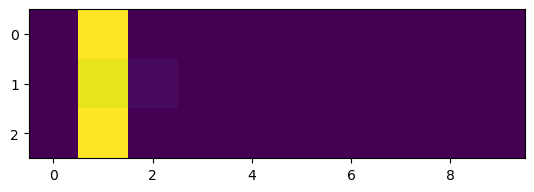

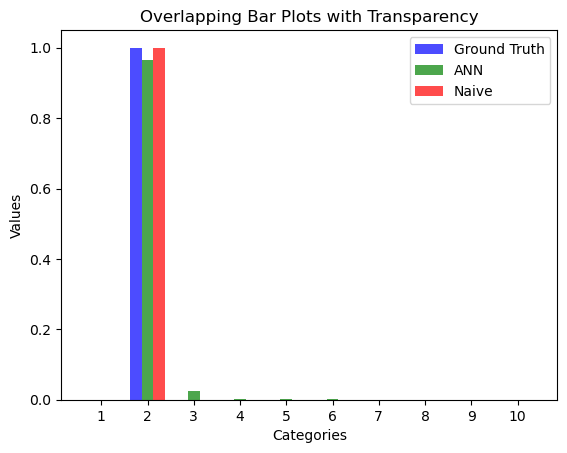

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
cell: 400
Error neural model 0.00019201565620544534
Error naoive model 0.0



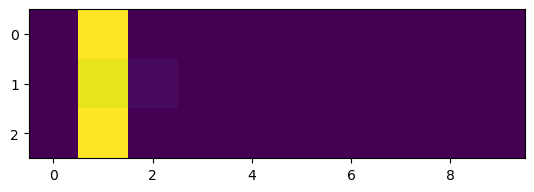

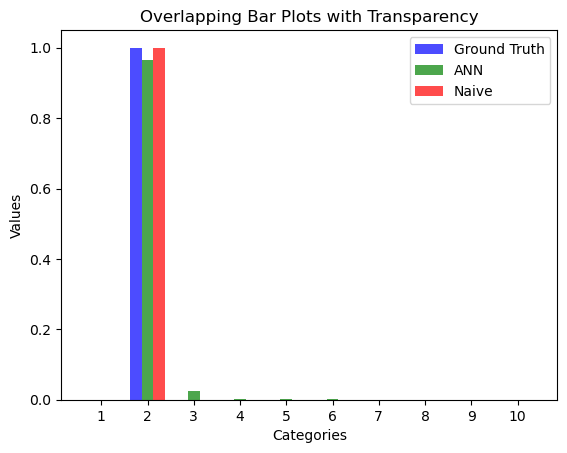

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
cell: 928
Error neural model 0.00019201565620544534
Error naoive model 0.0



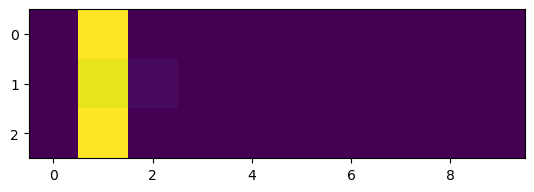

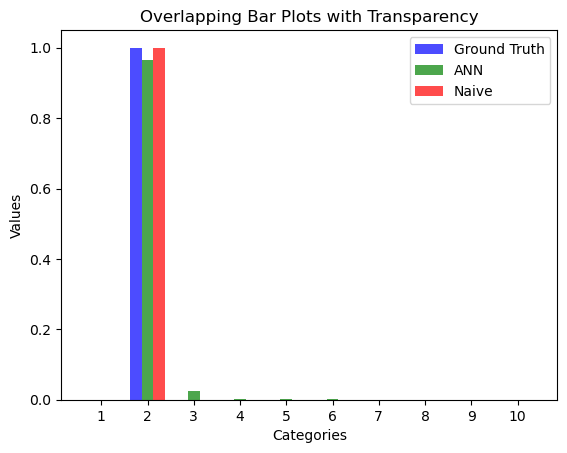

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
cell: 247
Error neural model 0.00019201565620544534
Error naoive model 0.0



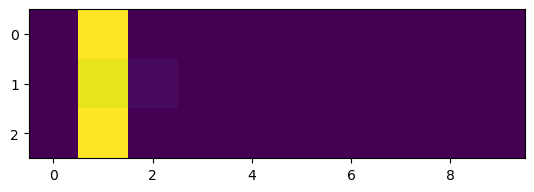

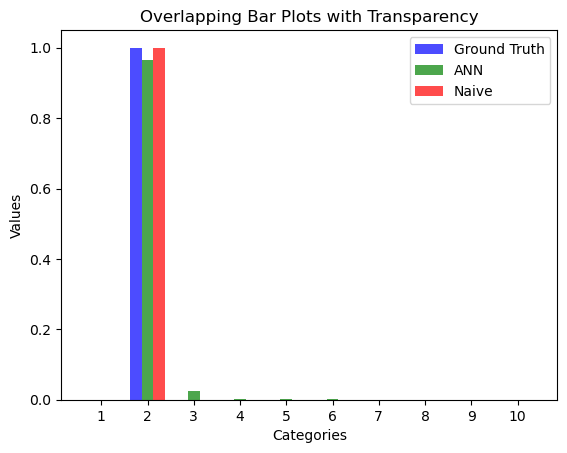

In [38]:
C = np.array([615, 276, 869, 547, 616, 410, 310, 342, 275])
C = np.array([  94,  400,  928,  247,  305, 1219,  497,  832,  422, 275])

for r in C[:4]:
    
    prediction =  model.predict(XTEH)

    predvsgt = np.zeros((3,10))

    #ground truth
    predvsgt[0,:] = YTEH[r]

    #prediction with neural model
    predvsgt[1,:] = prediction[r]

    #prediction of the naive model
    predvsgt[2,:] = YTEH[r-1]


    modelDif = np.mean((predvsgt[0,:]-predvsgt[1,:])**2)
    naiveDif = np.mean((predvsgt[0,:]-predvsgt[2,:])**2)
    print("cell:", r)
    print("Error neural model", modelDif)
    print("Error naoive model", naiveDif)

    print()
    plt.imshow(predvsgt)
    plt.show()

    generatePlots(predvsgt[0,:], predvsgt[1,:], predvsgt[2,:], 1+np.arange(len(predvsgt[0,:])))
    plt.show()

In [ ]:

# naive evaluation 
Diff = (YTEH[1:]-YTEH[:-1])
SquaredDiff = Diff**2 
print(SquaredDiff.shape)

naive_err = np.mean(np.mean(SquaredDiff, axis=1))

#np.mean(np.sum((YTEH[1:]-YTEH[:-1])**2, axis=1))

(9869, 10)


In [ ]:
# Neural network 
Diff = (YTEH-prediction)
SquaredDiff = Diff**2 
print(SquaredDiff.shape)
ann_err =  np.mean(np.mean(SquaredDiff, axis=1))


(9870, 10)


<BarContainer object of 2 artists>

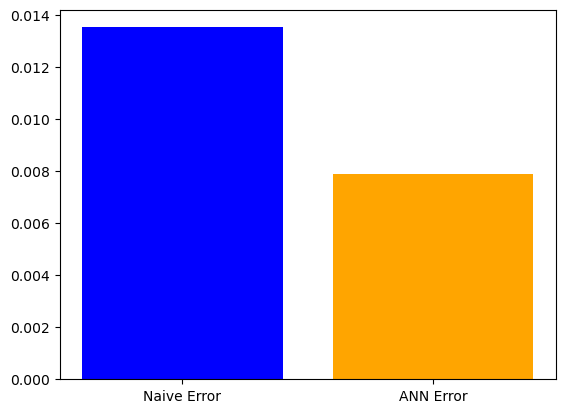

In [ ]:
# Sample data
labels = ['Naive Error', 'ANN Error']
errors = [naive_err, ann_err]  # Replace with your actual error values

# Create bar chart
plt.bar(labels, errors, color=['blue', 'orange'])

<BarContainer object of 2 artists>

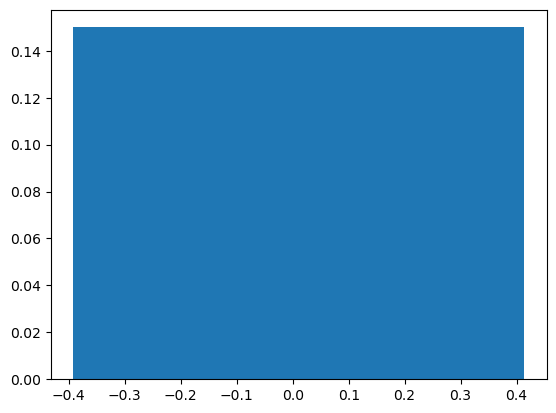

In [ ]:
plt.bar([naive_err, ann_err], height = 0.15)

In [ ]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)
    Make a bar plot.
    
    The bars are positioned at *x* with the given *align*\ment. Their
    dimensions are given by *height* and *width*. The vertical baseline
    is *bottom* (default 0).
    
    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.
    
    Parameters
    ----------
    x : float or array-like
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    height : float or array-like
        The height(s) of the bars.
    
    width : float or array-like, default: 0.8
        The width(s) of the bars.
    
    bottom : float or array-like, default: 0
        The y coordinate(s) of the bottom side(s) of the bars.
    
    align : {'center', 'edge'}, default: 'center'
        Alignment of the bars to the *x* coord

In [ ]:
Z[:, notDist] =1

on = np.zeros(len(notDist))
on[notDist] = 1
Z[:, 1+2] 
plt.imshow(Z)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
ZZ.shape



TR = ZZ[:20]

(7051, 38)

In [ ]:
#No toda la region cuadrada 
Y = 1985
uniqueGridCodes = np.unique(bahia_D2NF["Grid30"][bahia_D2NF[Y]>0])


In [ ]:
GridCell = bahia_D2NF["Grid30"]==uniqueGridCodes[0]

#GridCell = bahia_D2NF["Grid30"]== 1145

In [ ]:
(bahia_D2NF[Y]>0)*(GridCell)

0          False
1          False
2          False
3          False
4          False
           ...  
1092901    False
1092902    False
1092903    False
1092904    False
1092905    False
Length: 1092906, dtype: bool

In [ ]:
GridCell

0          False
1          False
2          False
3          False
4          False
           ...  
1092901    False
1092902    False
1092903    False
1092904    False
1092905    False
Name: Grid30, Length: 1092906, dtype: bool

In [ ]:
#prediction for H steps ahead
H = 1

#number of observed year to produce a prediction
LAGS = 4

#squared region defined by Psize*2+1
Psize = 0

https://asu.elsevierpure.com/en/publications/geographically-weighted-regression-a-method-for-exploring-spatial#:~:text=Spatial%20nonstationarity%20is%20a%20condition,the%20structure%20within%20the%20data.